## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)



#### Part I - Probability



In [258]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

`1.`  Reading in the `ab_data.csv` data. Store it in `df`.  

In [259]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b.  The number of rows in the dataset.

In [260]:
df.size

1472390

In [261]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [262]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [263]:
total_counts=df.count().converted
total_counts

294478

In [264]:
count=df.converted.value_counts()
convertedCount = (count[1]/total_counts)*100
convertedCount

11.96591935560551

e. The number of times the `new_page` and `treatment` don't line up.

In [265]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

In [266]:
df['landing_page'].value_counts()

new_page    147239
old_page    147239
Name: landing_page, dtype: int64

In [267]:
newpage_df = df.query('group == "treatment"')
notmatch_count1 = newpage_df.query('landing_page == "old_page"')['landing_page'].count()
controlpage_df = df.query('group == "control"')
notmatch_count2 = controlpage_df.query('landing_page == "new_page"')['landing_page'].count()
count = notmatch_count1 + notmatch_count2
print('Number of times the new_page and treatment donot line up:', count )

Number of times the new_page and treatment donot line up: 3893


 Rows with missing values

In [268]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [269]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` The rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page** These rows can be dropped.
The new dataset is stored in df2


In [270]:
drop_ind = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index
drop_ind

Int64Index([    22,    240,    308,    327,    357,    490,    685,    713,
               776,    846,
            ...
            293817, 293888, 293894, 293917, 293996, 294014, 294200, 294252,
            294253, 294331],
           dtype='int64', length=3893)

In [271]:
df.drop(labels = None, axis=1,index=drop_ind,inplace = True)
df2=df

In [272]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. Number of unique **user_id**s are in **df2**

In [273]:
df2['user_id'].nunique()

290584

In [274]:
duplicate_user = df2[df2.duplicated(keep=False,subset=['user_id'])]

c. The row information for the repeat **user_id**

In [275]:
duplicate_user

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, from **df2**.

In [276]:
df2.drop(labels = None, axis=1,index=2893,inplace = True)

In [277]:
duplicate_user = df2[df2.duplicated(keep=False,subset=['user_id'])]
duplicate_user

,user_id,timestamp,group,landing_page,converted


In [278]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB



a. The probability of an individual converting regardless of the page he receives:

In [279]:
df2[df2['converted'] == 1].count()['converted']/df2.shape[0]

0.11959708724499628

b. The probability of  an individual in the `control` group,that he converted:

In [280]:
control_df = df2.query('group == "control"')
control_con = control_df[control_df['converted'] == 1].count()['converted']/control_df.shape[0]
control_con 

0.1203863045004612

c. The probability of an individual in the `treatment` group, that he converted:

In [281]:
control_df = df2.query('group == "treatment"')
treatment_con = control_df[control_df['converted'] == 1].count()['converted']/control_df.shape[0]
treatment_con

0.11880806551510564

d.The probability of an individual received the new page:

In [282]:
df2[df2['group'] == 'treatment'].count()['landing_page']/df2.shape[0]

0.5000619442226688

e. Conclusion from above results:

#### The probability of conversion from the control group and from the treatment group is similar to probability of conversion regardless of the page.
#### So there is not enough evidence to say that new treatment page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test





#### Null hypothesis : pNew <= pOld 
#### Null hypothesis: The probability of conversion using new page is same or less as using the old page.
#### Alternative hypothesis  pNew > pOld 
#### Alternative hypothesis: The probability of conversion using new page is better than using the old page.

In [283]:
# Compute the observed difference in conversion
obs_diff = treatment_con - control_con

# Display observed difference
obs_diff

-0.0015782389853555567

a. The **convert rate** for $p_{new}$ under the null? 

In [284]:
p_New = df2.converted.mean()
p_New

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [285]:
p_Old = df2.converted.mean()
p_Old

0.11959708724499628

c. What is $n_{new}$?

In [286]:
n_New =  df2.query('group == "treatment"').count()['group']
n_New

145310

d. What is $n_{old}$?

In [287]:
n_Old = df2.query('group == "control"').count()['group']
n_Old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [288]:
new_page_converted=np.random.choice([0,1],size=n_New, p=[p_New,1-p_New])
new_page_converted
unique_values, occurrence_count =np.unique(new_page_converted, return_counts=True)
pNew=occurrence_count[1]/np.size(new_page_converted)


f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [289]:
old_page_converted=np.random.choice([0,1],size=n_Old, p=[p_Old,1-p_Old])
old_page_converted
unique_values, occurrence_count =np.unique(old_page_converted, return_counts=True)
pOld = occurrence_count[1]/np.size(old_page_converted)


In [290]:
new_page_converted.mean()- old_page_converted.mean()

-0.0013537978315356636

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [291]:
pNew - pOld


-0.0013537978315356636

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [292]:
# Create a sampling distribution of the difference in proportions with bootstrapping
diffs = []
size = df2.shape[0]
for _ in range(10000):
    b_samp = df2.sample(size, replace=True)
    old_page_converted=np.random.choice([0,1],size=n_Old, p=[p_Old,1-p_Old])
    unique_values, occurrence_count =np.unique(old_page_converted, return_counts=True)
    pOld = occurrence_count[1]/np.size(old_page_converted) 
    new_page_converted=np.random.choice([0,1],size=n_New, p=[p_New,1-p_New])
    unique_values, occurrence_count =np.unique(new_page_converted, return_counts=True)
    pNew=occurrence_count[1]/np.size(new_page_converted)
    diffs.append(pNew - pOld)

i. Plot a histogram of the **p_diffs**.  

(array([4.900e+01, 3.230e+02, 1.243e+03, 2.705e+03, 3.099e+03, 1.839e+03,
        6.080e+02, 1.260e+02, 7.000e+00, 1.000e+00]),
 array([-0.00413452, -0.00315511, -0.00217569, -0.00119628, -0.00021687,
         0.00076254,  0.00174195,  0.00272136,  0.00370077,  0.00468018,
         0.00565959]),
 <a list of 10 Patch objects>)

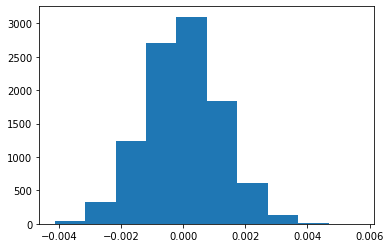

In [293]:
# Convert to numpy array
diffs = np.array(diffs)


# Plot sampling distribution
plt.hist(diffs)


j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

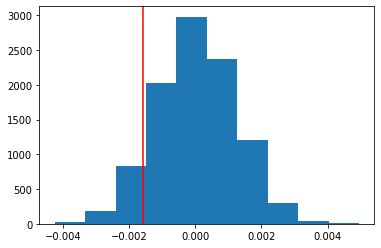

In [297]:
# Simulate distribution under the null hypothesis
null_vals = np.random.normal(0, diffs.std(), diffs.size)

# Plot the null distribution
plt.hist(null_vals);

# plot line for observed statistic
plt.axvline(obs_diff, c='red')


In [298]:
# Compute p-value
(null_vals > obs_diff).mean()

0.9073

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

#### The above value is called p-value.The probability of observing our statistic or a more extreme statistic from if the null hypothesis is true. Sample observed difference is -0.0015 and p-value for the population is 0.9012 . We will apply 0.05 as level of significance.
#### As  p-value 0.9 >  0.05  we fail to reject the null hypothesis using this test.

### Testing null hypothesis using Statsmodel

In [299]:
import statsmodels.api as sm

control_df2 = df2.query('group == "control"')
convert_old = control_df2[control_df2['converted'] == 1].count()['converted']
n_old = df2.query('group == "control"')['group'].count()
control_df2 = df2.query('group == "treatment"')
convert_new = control_df2[control_df2['converted'] == 1].count()['converted']
n_new = df2.query('group == "treatment"')['group'].count()
count=[convert_old,convert_new]
nobs = [n_old,n_new]

print(count)
print(nobs)


[17489, 17264]
[145274, 145310]


In [300]:
z_score, p_value = sm.stats.proportions_ztest(count, nobs, alternative='smaller')
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

#### Positive z-score value of 1.31 implies that raw score is 1 standard deviation above the mean.
#### A z-score, also known as a standard score, indicates the number of standard deviations a raw score lays above or below the mean. When the mean of the z-score is calculated it is always 0, and the standard deviation (variance) is always in increments of 1.
#### The for z-score of 1.31 , the corresponding area in the z-table is 0.9049 which translates into 90.49% of the standard normal distribution being below (or to the left) of the z-score.
#### We fail to reject the null hypothesis with 95% confidence as the z-score is less than 1.65. 
#### p_value of 0.9050 agrees with  that calculated with bootstrapping the sampling distribution above

<a id='regression'></a>
### Part III - A regression approach



a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

#### Answer : Logistical regression is well appropriate here as group,landing_page,convereted data columns are categorical . Converted column has values 0 and 1

In [301]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [302]:
control_df1 = df2.query('group == "control"')
convert_old = control_df1[control_df1['converted'] == 1].count()['converted']
control_df1 = df2.query('group == "treatment"')
convert_new = control_df1[control_df1['converted'] == 1].count()['converted']
convert_old,convert_new

(17489, 17264)

In [303]:
df2.describe()

,user_id,converted
count,290584.000000,290584.000000
mean,788004.876222,0.119597
std,91224.735468,0.324490
min,630000.000000,0.000000
25%,709034.750000,0.000000
50%,787995.500000,0.000000
75%,866956.250000,0.000000
max,945999.000000,1.000000


In [305]:
import statsmodels.api as sm
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

In [306]:

df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [307]:
df2['intercept'] = 1
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
#log_mod = sm.Logit(df2['ab_page'], df2[['intercept', 'converted']])

results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [308]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 07 Oct 2020   Pseudo R-squ.:               8.077e-06
Time:                        23:39:58   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

#### Answer:  p-value associated with ab_page = 0.190
#### This p-value is different from previous p-value as interpretation of this value in the model is different. The 2-tailed p-value used in testing the null hypothesis that the coefficient (parameter) is 0.
#### Here , null hypothesis would be being in treatment group in ab_page would not affect conversion rate.
####            Alternative hypotheis is being in treatment group (ab_page) would change odds of  conversion by 1.
#### Smaller p-values suggest being in treatement group is statistically significant in relating conversion.Coefficients having p-values less than alpha (0.05) are statistically significant.
#### A low p-value (< 0.05) indicates that you can reject the null hypothesis. 
#### Here p-value  0.190 > 0.05 which suggest we fail to reject null hypotheis


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

#### Answer:
#### Multiple regression is used to examine the relationship between several independent variables and a dependent variable. Multiple regression models allows  to analyze the relative influences of these independent, or predictor, variables on the dependent, or criterion, variable.The first advantage is the ability to determine the relative influence of one or more predictor variables to the criterion value. The second advantage is the ability to identify outliers, or anomalies.
##### Disadvantage: These often complex data sets can lead to false conclusions if they aren't analyzed properly.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [309]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')


In [310]:
countries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  290584 non-null  int64 
 1   country  290584 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


In [311]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 834778 to 934996
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   country       290584 non-null  object
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
 5   ab_page       290584 non-null  uint8 
 6   intercept     290584 non-null  int64 
dtypes: int64(2), object(4), uint8(1)
memory usage: 15.8+ MB


In [312]:
### Create the necessary dummy variables
df_new['ab_country1'] = pd.get_dummies(df_new['country'])['US']
df_new['ab_country2'] = pd.get_dummies(df_new['country'])['UK']
df_new['ab_country3'] = pd.get_dummies(df_new['country'])['CA']


In [313]:
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,ab_country1,ab_country2,ab_country3
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [314]:
df_new.tail()

,country,timestamp,group,landing_page,converted,ab_page,intercept,ab_country1,ab_country2,ab_country3
user_id,,,,,,,,,,
653118,US,2017-01-09 03:12:31.034796,control,old_page,0,0,1,1,0,0
878226,UK,2017-01-05 15:02:50.334962,control,old_page,0,0,1,0,1,0
799368,UK,2017-01-09 18:07:34.253935,control,old_page,0,0,1,0,1,0
655535,CA,2017-01-09 13:30:47.524512,treatment,new_page,0,1,1,0,0,1
934996,UK,2017-01-09 00:30:08.377677,control,old_page,0,0,1,0,1,0


In [315]:
df_new.describe()

,converted,ab_page,intercept,ab_country1,ab_country2,ab_country3
count,290584.000000,290584.000000,290584.0,290584.000000,290584.000000,290584.000000
mean,0.119597,0.500062,1.0,0.700723,0.249381,0.049896
std,0.324490,0.500001,0.0,0.457942,0.432655,0.217731
min,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.0,1.000000,0.000000,0.000000
75%,0.000000,1.000000,1.0,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.0,1.000000,1.000000,1.000000


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [316]:
### Fit Your Linear Model And Obtain the Results
df_new['intercept'] = 1
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'ab_country1','ab_country2']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 07 Oct 2020   Pseudo R-squ.:               2.323e-05
Time:                        23:40:36   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page        -0.0149      0.011     -1.307      0.191      -0.037       0.007
ab_country1     0.0408      0.027      1.516      0.130      -0.012       0.093
ab_country2     0.0506      0.028      1.784      0.074      -0.005       0.106
===============================================================================
"""

In [317]:
np.exp(results.params)

intercept      0.131332
ab_page        0.985168
ab_country1    1.041599
ab_country2    1.051944
dtype: float64

In [318]:
1/np.exp(-0.01490)

1.0150115583846535

In [319]:
df_new.groupby('converted').mean()

,ab_page,intercept,ab_country1,ab_country2,ab_country3
converted,,,,,
0,0.500510,1,0.700763,0.249098,0.050139
1,0.496763,1,0.700429,0.251460,0.048111


### Conclusions

#### 1 unit conversion rate, will be brought by users of country US 1.04 times more as likely holding all else constant.

#### 1 unit conversion rate, will be brought by users of country UK 1.05 times more as likely holding all else constant

#### For each 1 unit decrease in conversion receiving treatment page is 1.015 times more likely as holding all else constant.